# Execute a simple, custom, model

### Import cobrakbase

In [1]:
from pprint import pprint
# define the environment path 
import os
local_cobrakbase_path = os.path.join('C:', 'Users', 'Andrew Freiburger','Documents','Argonne','cobrakbase')
os.environ["HOME"] = local_cobrakbase_path

# import the models
from cobrakbase import KBaseAPI, Metabolite, Reaction, Model
token = 'WE6CHYRDTJSGOHFIDGPE7WYFT6PRPXJL'
kbase_api = KBaseAPI(token)

cobrakbase 0.2.8


### Define the model

In [6]:
# define metabolites
ACP_c = Metabolite(
    'cpd11628',
    name='acyl-carrier-protein',
    compartment='c')
omrsACP_c = Metabolite(
    'cpd15377',
    formula='C25H45N2O9PRS',
    name='3-Oxotetradecanoyl-acyl-carrier-protein',
    compartment='c')
co2_c = Metabolite('cpd00011', formula='CO2', name='CO2', compartment='c')
malACP_c = Metabolite(
    'cpd11492',
    formula='C14H22N2O10PRS',
    name='Malonyl-acyl-carrier-protein',
    compartment='c')
h_c = Metabolite('cpd00067', formula='H', name='H', compartment='c')
ddcaACP_c = Metabolite(
    'cpd11468',
    formula='C23H43N2O8PRS',
    name='Dodecanoyl-ACP-n-C120ACP',
    compartment='c')

# define reactions, with the metabolites
reaction = Reaction('R_3OAS140')
reaction.name = 'R_3OAS140'
reaction.add_metabolites({
    malACP_c: -1.0,
    h_c: -2.0,
    ddcaACP_c: -1.0,
    co2_c: 1.0,
    ACP_c: 1.0,
    omrsACP_c: 1.0
})

reaction2 = Reaction('rxn2')
reaction2.add_metabolites({
    malACP_c: -1.0,
    h_c: 1.0,
    ddcaACP_c: -1.0,
    co2_c: -1.0,
    ACP_c: 1.0
})
reaction2.name = 'rxn2'

# define the model, with the reactions
model = Model('test')
model.add_reactions([reaction, reaction2])
model.objective = reaction.flux_expression

for reaction in model.reactions:
    print(reaction)

R_3OAS140: 2.0 cpd00067 + cpd11468 + cpd11492 --> cpd00011 + cpd11628 + cpd15377
rxn2: cpd00011 + cpd11468 + cpd11492 --> cpd00067 + cpd11628


### Execute the model with custom kinetic data

C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\Andrew Freiburger\AppData\Local\Programs\Python\Python39\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


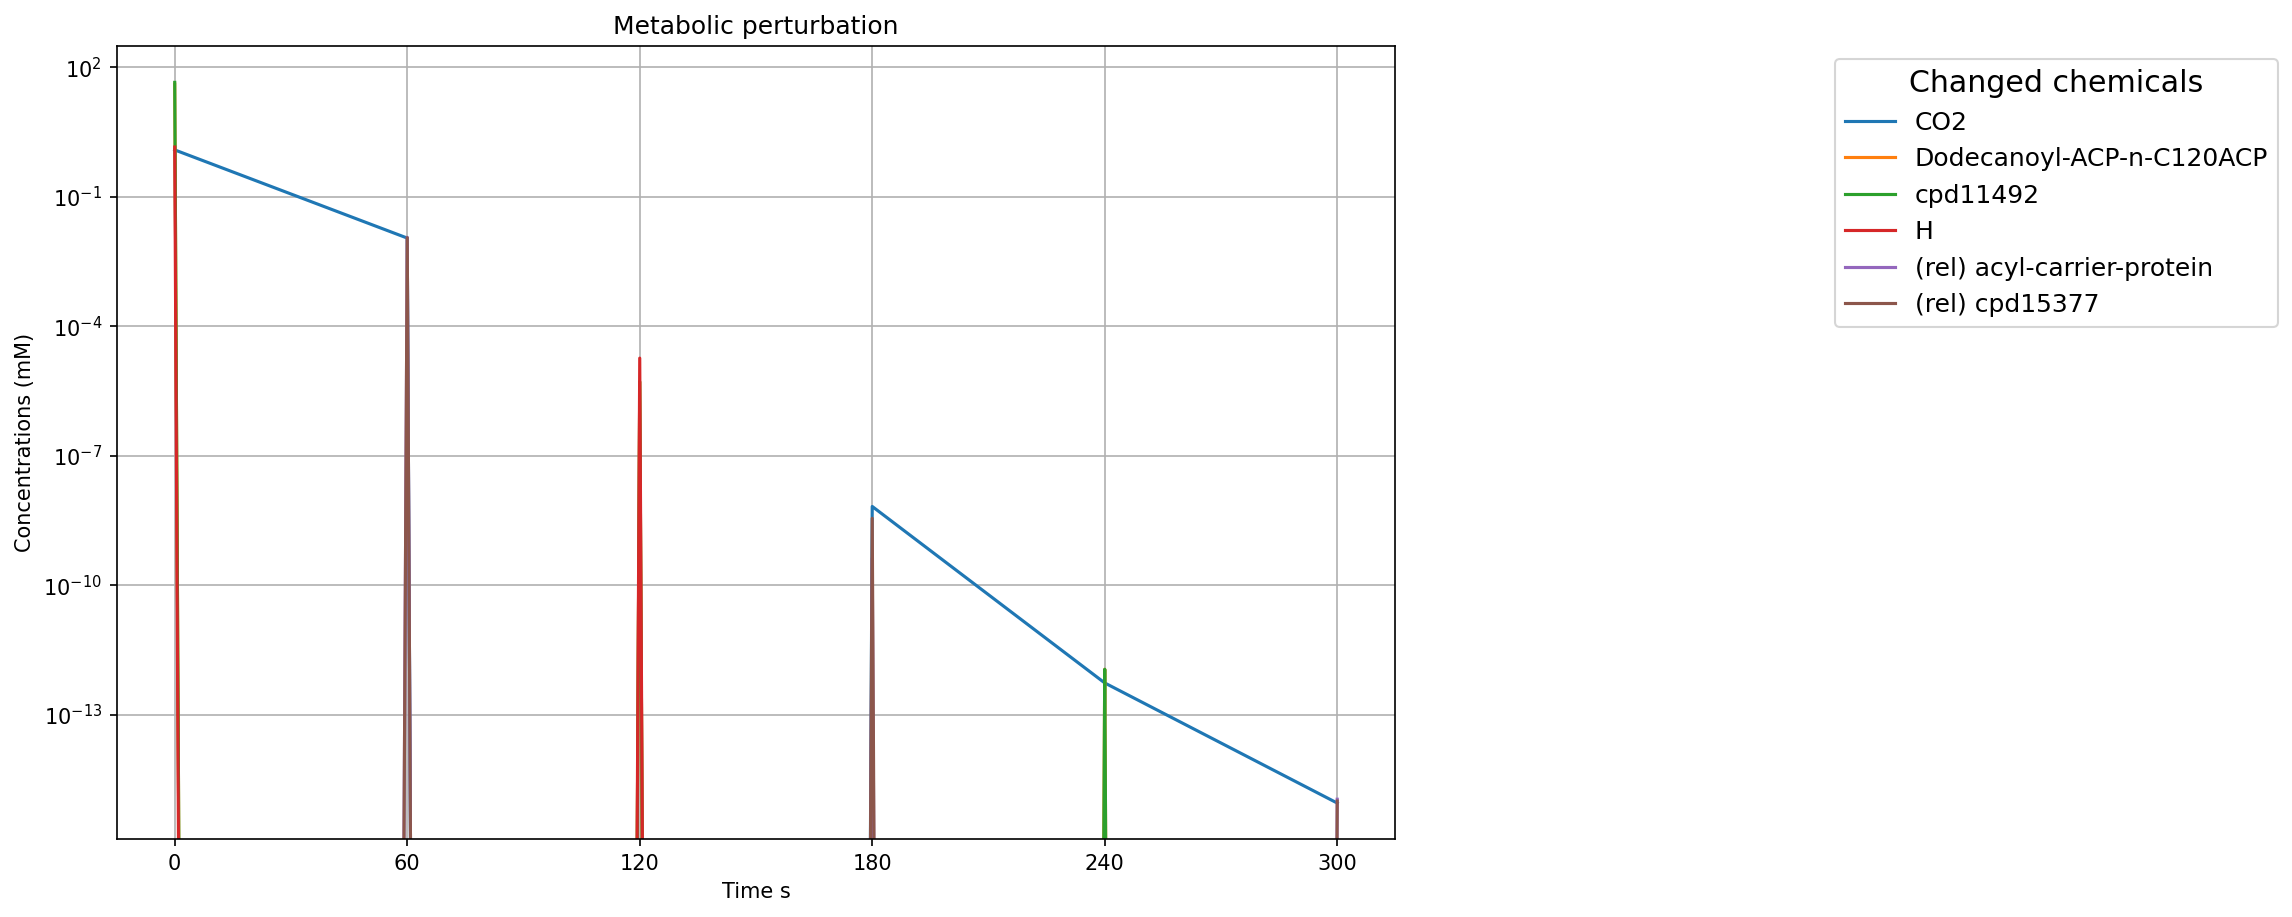

In [7]:
%run ../../modelseedpy/fbapkg/dfbapkg.py

# define arbitrary enzyme kinetics and rate equations
reaction_kinetics = {
    'R_3OAS140': {
        'source_1': {
            'substituted_rate_law': '(68.0*A*B)/(50.0*0.34*C+360.0*B+0.34*A+A*B*C)',
            "initial_concentrations_M": {
                "A": .0200,
                'C':.022,
                'B': .0014
            },
            "met_id": {
                'A': 'cpd11468',
                'B': 'cpd00067',
                'C': 'cpd11492'
            }
        }
    },
    'rxn2': {
        'source_1': {
            'substituted_rate_law': '(A*B)/(50.0*0.34*C+3*B+0.34*A+C)',
            "initial_concentrations_M": {
                "A": .0200,
                'C':.022,
                'B': .0012
            },
            "met_id": {
                'A': 'cpd11468',
                'B': 'cpd00011',
                'C': 'cpd11492'
            }
        }
    }
}

modelseed_db_path = os.path.join('..', '..', '..', 'ModelSEEDDatabase')
total_time = 5
timestep = 1
dfba = dFBAPkg(model, modelseed_db_path, verbose = False)
conc, fluxes = dfba.simulate(None, None, total_time, timestep, None, None, kinetics_data = reaction_kinetics, labeled_plots = False, export = False)

# Execute SABIO-RK kinetics data 

In [4]:
display(dfba.concentrations)
print(type(dfba.concentrations))
dfba.print_lp('dFBA')

,0 min,1 min,2 min,3 min,4 min,5 min
metabolite (ΔmM),,,,,,
CO2,1.2,0.010913,-0.000010,6.655375e-09,5.447921e-13,9.012824e-16
Dodecanoyl-ACP-n-C120ACP,40.0,-0.011352,0.000005,-4.178066e-10,1.127642e-12,-1.105001e-15
Malonyl-acyl-carrier-protein,44.0,-0.011352,0.000005,-4.178066e-10,1.127642e-12,-1.105001e-15
H,1.4,-0.022046,0.000018,-1.019197e-08,-2.533672e-13,-1.904424e-15
acyl-carrier-protein,0.0,0.011352,-0.000005,4.178066e-10,-1.127642e-12,1.105001e-15
3-Oxotetradecanoyl-acyl-carrier-protein,0.0,0.011133,-0.000008,3.536591e-09,-2.914249e-13,1.003142e-15


<class 'pandas.core.frame.DataFrame'>


In [5]:
# %run ../../modelseedpy/fbapkg/dynamicfbapkg.py
# import cobra 
# model = cobra.io.read_sbml_model('../iSB619.xml')

# # define in the initial conditions
# initial_concentrations = {"ATP":200, "ADP":100}

# # import enzyme kinetics and rate equations
# with open('../sabio_proccessed.json', 'rb') as f:
#     reaction_kinetics = json.load(f)

# # execute the package
# total_time = 5
# timestep = 1
# dfba = dynamicFBAPkg(model, total_time, timestep, initial_concentrations, reaction_kinetics, verbose = False)
# fluxes_df, concentrations_df, solutions = dfba.simulate()